插值

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import griddata
import os
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

数据准备

In [50]:
#准备数据,插值区域的经纬度
top = 35.8166666668
bottom = 32.8083333335
left = 88.5583333333
right = 93.45
target_shape = [361,587]#插值数组的shape
path=r'D:/Data/TPHiPr_Hourly/'#文件存放路径
new_path = r'D:/Data/TPHiPr_Hourly/interpolation'#输出文件存放路径
xy = xr.open_dataset('D:/CSSP/pause/tuotuorivermask.nc')#经纬度文件
#读取经纬度数据
lon = xy['lon'].values.tolist()
lat = xy['lat'].values.tolist()
lon = np.array(lon)
lat = np.array(lat)

定义函数

In [47]:
def clip_data(bottom,top,left,right,datafilepath):#数组clip函数
    ds = xr.open_dataset(datafilepath,engine='netcdf4')
    lat = ds['latitude'].values.tolist()#读取纬度并转化为列表格式
    lon = ds['longitude'].values.tolist()#读取经度
    data_all = ds['prcp'].values
    
    #查询离经纬度最近的格点
    lat_index_top = lat.index(min(lat,key = lambda x:abs(x - top)))
    lat_index_bottom = lat.index(min(lat,key = lambda x:abs(x - bottom)))
    lon_index_right = lon.index(min(lon,key = lambda x:abs(x - right)))
    lon_index_left = lon.index(min(lon,key = lambda x:abs(x - left)))
    data =  data_all[:,lat_index_top:lat_index_bottom,lon_index_left:lon_index_right]#从list中切割出需要的数据
    
    data_array = np.array(data)#转为数组
    return data_array
#2维插值函数
def interpolate_2d_array(original_array, target_shape):
    original_shape = original_array.shape
    x = np.linspace(0, original_shape[1] - 1, original_shape[1])  # 原始数组的列索引
    y = np.linspace(0, original_shape[0] - 1, original_shape[0])  # 原始数组的行索引
    xx, yy = np.meshgrid(x, y)  # 创建原始数组的网格索引


    target_x = np.linspace(0, original_shape[1] - 1, target_shape[1])
    target_y = np.linspace(0, original_shape[0] - 1, target_shape[0])  # 目标数组的行索引
    target_xx, target_yy = np.meshgrid(target_x, target_y)  # 创建目标数组的网格索引

    interpolated_array = griddata((xx.flatten(), yy.flatten()), original_array.flatten(), (target_xx, target_yy), method='linear')

    return interpolated_array
#3维插值函数
def interpolate_3d_array(original_array, target_shape):#输入原始数组和插值数组的shape
    original_shape = original_array.shape
    original_data = np.empty((original_shape[1],original_shape[2]))
    interpolated_array = np.empty((52,target_shape[0],target_shape[1]))
    for i in range (52):
        original_data = original_array[i,:,:]
        x = np.linspace(0, original_shape[2] - 1, original_shape[2])  # 原始数组的列索引
        y = np.linspace(0, original_shape[1] - 1, original_shape[1])  # 原始数组的行索引
        xx, yy = np.meshgrid(x, y)  # 创建原始数组的网格索引

        target_x = np.linspace(0, original_shape[1] - 1, target_shape[1])
        target_y = np.linspace(0, original_shape[0] - 1, target_shape[0])  # 目标数组的行索引
        target_xx, target_yy = np.meshgrid(target_x, target_y)  # 创建目标数组的网格索引

        interpolated_data = griddata((xx.flatten(), yy.flatten()), original_data.flatten(), (target_xx, target_yy), method='linear')#二维线性插值
        interpolated_array[i,:,:] = interpolated_data
    return interpolated_array

def create_newnc(newfilepath,lon,lat,var_data,var_name):
    ds_w = nc.Dataset(newfilepath,'w',format = 'NETCDF4')#创建输出文件
    
    #创建变量维度
    ds_w.createDimension('lon',66)
    ds_w.createDimension('lat',25)
    ds_w.createDimension('time',52)
   
    #创建变量
    ds_w.createVariable('lat',np.float32,('lat'))  
    ds_w.createVariable('lon',np.float32,('lon'))
    ds_w.createVariable('time',np.int64,('time'))
    ds_w.createVariable(var_name , np.float32, ('time','lat','lon'))
    ds_w.variables[var_name].setncattr('units', 'mm/hour')#输入单位
    
    #写入变量
    ds_w.variables['lon'][:] = lon
    ds_w.variables['lat'][:] = lat

    ds_w.variables[var_name][:] = var_data#输入上一步处理的数据
    
    #关闭文件
    ds_w.close()
def create_2dnewnc(newfilepath,lon,lat,var_data,varname):#将插值后的数据写入新nc文件中
    ds_w = nc.Dataset(newfilepath,'w',format = 'NETCDF4')#创建输出文件
    
    #创建变量维度,维度要改
    ds_w.createDimension('lon',720)
    ds_w.createDimension('lat',361)
    
    #创建变量
    ds_w.createVariable('lat',np.float32,('lat'))  
    ds_w.createVariable('lon',np.float32,('lon'))
    ds_w.createVariable(varname , np.float32, ('lat','lon'))
    
    #写入变量
    ds_w.variables['lon'][:] = lon
    ds_w.variables['lat'][:] = lat
    ds_w.variables[varname][:] = var_data



插值完成准备生成nc文件

In [48]:
path =r'D:/Data/TPHiPr_Daily/'
newpath = r'D:/Data/TPHiPr_Daily/inter/'
for year in range (1982,1982):#1979——1987年循环

    l1=os.listdir(path+str(year))
    print(l1)
    for i in l1 :
        datafilepath = path+str(year)+'/'+i
        newfile = new_path+str(year)+'/'+'inter'+i
        prcp_tuo_array = clip_data(bottom,top,left,right,datafilepath)
        prcpinter_array = interpolate_2d_array(prcp_tuo_array, target_shape)
        create_newnc(newfile,lon,lat,prcpinter_array)
        print(newfile)


测试

In [51]:
datafilepath = 'D:/Data/TPHipr_Hourly/1979/tpmfd_prcp_h_19790101_00_23.nc'
newfile = 'D:/Data/TPHipr_Hourly/interpolation/tpmfd_prcp_h_19790101_00_23.nc'
data_tuo_array = clip_data(bottom,top,left,right,datafilepath)
datainter_tuo_array = interpolate_2d_array(data_tuo_array, target_shape)
create_newnc(newfile,lon,lat,datainter_tuo_array)

ValueError: unrecognized engine 'netcdf4' must be one of your download engines: ['scipy', 'store']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [ ]:
dx = xr.open_dataset('D:/Data/TPHipr_Hourly/interpolation/tpmfd_prcp_h_19790101_00_23.nc')
dx = dx.variables['APCP']
dx = np.array(dx)
dx.shape

(24, 361, 587)

0.5dgree to 0.25 dgree

In [3]:
import numpy as np
import xarray as xr
import netCDF4
from scipy.interpolate import griddata

def interpolate_05_to_025(data_array):
    """Interpolate 0.5° grid to 0.25° grid using bilinear interpolation
    
    Args:
        data_array (xarray.DataArray): Input 2D data with latitude and longitude coordinates
    
    Returns:
        xarray.DataArray: Interpolated 0.25° grid data
    """
    # 1. 确保数据维度顺序为 (lat, lon)
    if data_array.dims != ('latitude', 'longitude'):
        data_array = data_array.transpose('latitude', 'longitude')
    
    # 2. 获取原始坐标
    lat_in = data_array.latitude.values
    lon_in = data_array.longitude.values
    values = data_array.values

    # 3. 创建目标0.25°网格
    lat_out = np.arange(lat_in.min(), lat_in.max() + 0.25/2, 0.25)
    lon_out = np.arange(lon_in.min(), lon_in.max() + 0.25/2, 0.25)
    
    # 4. 生成原始网格点坐标矩阵
    lon_grid, lat_grid = np.meshgrid(lon_in, lat_in)
    points = np.vstack((lat_grid.ravel(), lon_grid.ravel())).T

    # 5. 生成目标网格点坐标矩阵
    lon_grid_out, lat_grid_out = np.meshgrid(lon_out, lat_out)
    grid_points = (lat_grid_out, lon_grid_out)

    # 6. 执行双线性插值
    interpolated = griddata(
        points=points,
        values=values.ravel(),
        xi=grid_points,
        method='linear'
    )

    # 7. 创建Xarray DataArray并保留元数据
    coords = {
        'latitude': lat_out,
        'longitude': lon_out
    }
    interpolated_da = xr.DataArray(
        data=interpolated.reshape(len(lat_out), len(lon_out)),
        coords=coords,
        dims=['latitude', 'longitude'],
        name=data_array.name,
        attrs=data_array.attrs
    )

    return interpolated_da

# 示例用法
if __name__ == "__main__":
    # 生成示例0.5°数据（假设数据范围为10°x10°）
    lat = np.arange(27.25, 39.75, 0.5)  # 30°N到40°N
    lon = np.arange(75.25, 104.75, 0.5)  # 100°E到110°E
    ds = xr.open_dataset(r'D:/Data/SJY_GLACIER/Grided mass change/dh_swr_0.5deg_1970s-2000_v2.nc')
    data = ds['mb']

    # 创建Xarray DataArray
    da = xr.DataArray(
        data=data,
        coords={'latitude': lat, 'longitude': lon},
        dims=['latitude', 'longitude'],
        name='mb'
    )

    # 执行插值
    da_025 = interpolate_05_to_025(da)

    # 验证插值结果
    print("Original shape:", da.shape)
    print("Interpolated shape:", da_025.shape)
    print("Sample interpolated value at (30.25, 100.25):", 
          da_025.sel(latitude=30.25, longitude=100.25, method='nearest').values)

    # 可视化对比
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    da.plot(cmap='viridis')
    plt.title('Original 0.5° Grid')

    plt.subplot(1, 2, 2)
    da_025.plot(cmap='viridis')
    plt.title('Interpolated 0.25° Grid')

    plt.tight_layout()
    plt.show()



AttributeError: module 'netCDF4' has no attribute 'Dataset'

In [71]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

def downscale_mb(input_path, output_path, target_res=0.25):
    try:
        # 读取原始数据
        ds = xr.open_dataset(input_path, engine='h5netcdf')
        mb_data = ds['mb']  # 提取 mb 变量
        lat = ds['y'].values  # 纬度坐标（降序排列）
        lon = ds['x'].values  # 经度坐标（升序排列）

        print(f"原始数据维度：{mb_data.shape}")  # (N, M)

        # 检查数据是否全为 NaN
        if np.all(np.isnan(mb_data)):
            raise ValueError("数据全为 NaN，无法插值！")

        # 创建原始网格
        lon_grid, lat_grid = np.meshgrid(lon, lat)  # (N, M)

        # 生成新坐标（0.25°分辨率）
        new_lat = np.arange(lat[0], lat[-1] - target_res, -target_res)  # 纬度降序
        new_lon = np.arange(lon[0], lon[-1] + target_res, target_res)   # 经度升序

        # 验证新坐标是否为空
        if len(new_lat) == 0 or len(new_lon) == 0:
            raise ValueError("生成的新坐标数组为空，请检查范围和步长！")

        # 创建目标网格
        new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

        # 展平原始网格和数据
        points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))  # (N*M, 2)
        values = mb_data.values.ravel()  # (N*M,)

        # 执行双线性插值
        interpolated = griddata(
            points=points,
            values=values,
            xi=(new_lon_grid, new_lat_grid),
            method='linear',
            fill_value=np.nan
        )

        # 保存结果为新的 NetCDF 文件
        interpolated_da = xr.DataArray(
            interpolated,
            coords={'y': new_lat, 'x': new_lon},
            dims=['y', 'x']
        )
        interpolated_da.to_netcdf(output_path, engine='h5netcdf')
        print(f"插值成功！文件保存至：{output_path}")

    except Exception as e:
        print(f"ERROR: {str(e)}")
        print("请检查以下问题：")
        print("1. 文件路径是否正确")
        print("2. 变量名是否为 'mb'")
        print("3. 数据是否包含有效值（非全 NaN）")

# 执行插值
input_file = r'D:/Data/SJY_GLACIER/Grided mass change/dh_swr_0.1deg_1970s-2000_v2.nc'
output_file = input_file.replace('.nc', '_mb_0.25deg.nc')
downscale_mb(input_file, output_file)



原始数据维度：(130, 300)
插值成功！文件保存至：D:/Data/SJY_GLACIER/Grided mass change/dh_swr_0.1deg_1970s-2000_v2_mb_0.25deg.nc


C:\Users\DELL\AppData\Local\Temp\ipykernel_143260\2574939380.py:84: RuntimeWarning: invalid value encountered in log
  slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(np.log(x), np.log(y))


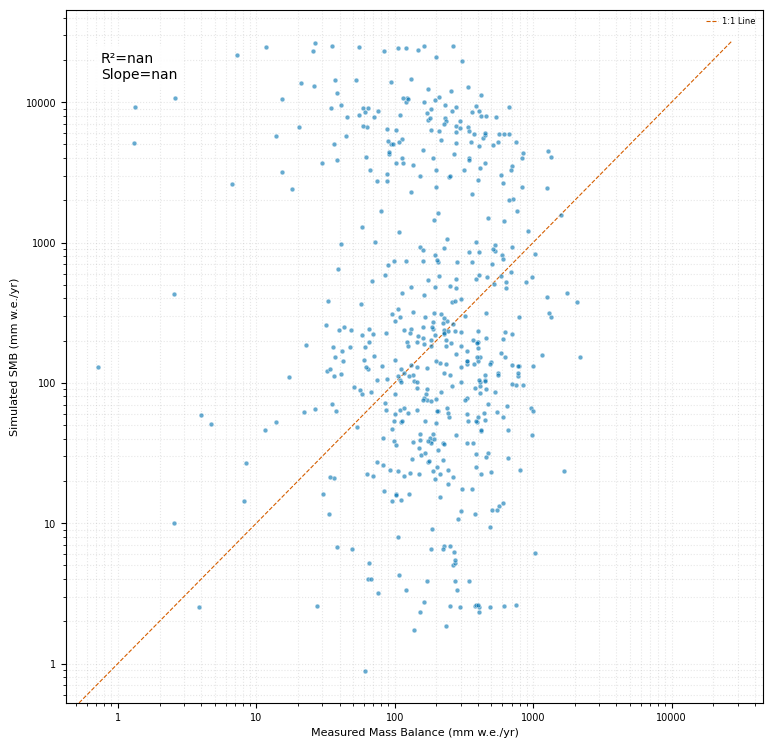

In [ ]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

def crop_and_downscale(input_path, output_path,
                       global_lat_range=(-55.875, 83.875),
                       global_lon_range=(-179.875, 179.875),
                       target_lat_range=(27.25, 39.75),
                       target_lon_range=(75.25, 104.75),
                       target_shape=(130, 300)):
    try:
        # 读取原始数据
        ds = xr.open_dataset(input_path, engine='h5netcdf')
        mb_data = ds['SMB_sum']  # 提取变量
        print(f"原始数据维度：{mb_data.shape}")  # (560, 1440)

        # 检查数据是否全为 NaN
        if np.all(np.isnan(mb_data)):
            raise ValueError("数据全为 NaN，无法裁剪！")

        # 根据索引生成纬度和经度数组
        lat = np.linspace(global_lat_range[0], global_lat_range[1], mb_data.shape[0])  # 纬度降序
        lon = np.linspace(global_lon_range[0], global_lon_range[1], mb_data.shape[1])  # 经度升序

        # 找到目标裁剪范围对应的索引
        lat_indices = np.where((lat <= target_lat_range[1]) & (lat >= target_lat_range[0]))[0]
        lon_indices = np.where((lon >= target_lon_range[0]) & (lon <= target_lon_range[1]))[0]

        # 验证裁剪范围是否有效
        if len(lat_indices) == 0 or len(lon_indices) == 0:
            raise ValueError("裁剪范围无效，请检查纬度和经度范围！")

        # 裁剪数据
        cropped_lat = lat[lat_indices]
        cropped_lon = lon[lon_indices]
        cropped_data = mb_data[lat_indices.min():lat_indices.max()+1,
                               lon_indices.min():lon_indices.max()+1]

        print("裁剪后纬度范围：", cropped_lat[0], "到", cropped_lat[-1])
        print("裁剪后经度范围：", cropped_lon[0], "到", cropped_lon[-1])

        # 创建裁剪后的 DataArray
        cropped_da = xr.DataArray(
            cropped_data,
            coords={'y': cropped_lat, 'x': cropped_lon},
            dims=['y', 'x']
        )

        # 降尺度到目标分辨率 (130, 300)
        new_lat = np.linspace(cropped_lat[0], cropped_lat[-1], target_shape[0])  # 新纬度
        new_lon = np.linspace(cropped_lon[0], cropped_lon[-1], target_shape[1])  # 新经度

        # 创建新的网格
        new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

        # 展平原始网格和数据
        lon_grid, lat_grid = np.meshgrid(cropped_lon, cropped_lat)  # 原始网格
        points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))  # 原始坐标点
        values = cropped_data.values.ravel()  # 原始值

        # 执行双线性插值
        interpolated = griddata(
            points=points,
            values=values,
            xi=(new_lon_grid, new_lat_grid),
            method='linear',
            fill_value=np.nan
        )

        # 创建降尺度后的 DataArray，并命名为 smb
        downscaled_da = xr.DataArray(
            interpolated,
            coords={'y': new_lat, 'x': new_lon},
            dims=['y', 'x'],
            name='mb'  # 设置变量名为 smb
        )

        # 保存结果为新的 NetCDF 文件
        downscaled_ds = downscaled_da.to_dataset()  # 转换为 Dataset
        downscaled_ds.to_netcdf(output_path, engine='h5netcdf')
        print(f"降尺度成功！文件保存至：{output_path}")
        print(f"降尺度后数据维度：{interpolated.shape}")

    except Exception as e:
        print(f"ERROR: {str(e)}")
        print("请检查以下问题：")
        print("1. 文件路径是否正确")
        print("2. 变量名是否为 'SMB_sum'")
        print("3. 数据是否包含有效值（非全 NaN）")

# 执行裁剪和降尺度
input_file = r'D:/CSSP/out_data/GLOBAL/CSSPsurface_SMB_GLOBAL1981_1981_glc.nc'
output_file = input_file.replace('.nc', '_cropped_downscaled.nc')
crop_and_downscale(input_file, output_file)


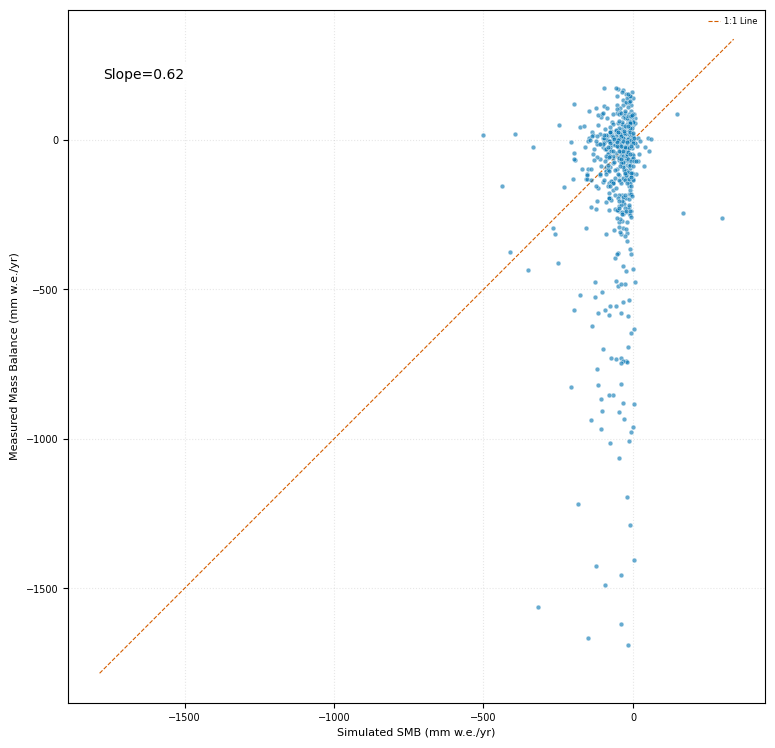

In [182]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from scipy import stats  # 添加此导入语句
# 设置期刊规范参数
rcParams['font.family'] = 'DejaVu Sans'
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 0.8
rcParams['xtick.major.width'] = 0.8
rcParams['ytick.major.width'] = 0.8

# 读取数据（根据实际变量名调整）
ds1 = xr.open_dataset(
    r'D:/Data/SJY_GLACIER/Grided mass change/dh_swr_0.1deg_1970s-2000_v2.nc', engine='h5netcdf'
)
ds2 = xr.open_dataset(
    r'D:/CSSP/out_data/GLOBAL/CSSPsurface_SMB_GLOBAL1981_1981_glc_cropped_downscaled.nc', engine='h5netcdf'
)

# 提取目标变量（根据实际变量名修改）
mb1 = ds1['mb']          # 假设第一个文件变量名为'mb'（单位：m/yr）
mb2 = ds2['mb']          # 假设第二个文件变量名为'mb'（单位：mm w.e./yr）

# 处理时间维度（示例：取1981年数据）
# 第一个文件时间切片（假设时间维度为'time'）
# 注意：如果时间维度存在，需要显式选择时间切片
# 例如：mb1_selected = mb1.sel(time='1981')
mb1_selected = mb1       # 假设数据已按年份切片

# 第二个文件假设为单年数据（1981年）
mb2_selected = mb2

# 空间对齐（将第二个数据集重采样到第一个的网格）
# 注意：如果网格不一致，需要显式插值
# 例如：mb2_aligned = mb2_selected.interp(lat=mb1.lat, lon=mb1.lon, method='nearest')
mb2_aligned = mb2_selected  # 假设空间网格已对齐

# 单位统一（假设mb1是m/yr，转换为mm w.e./yr）
mb1_mm = mb1_selected * 1000  # 1m = 1000mm

# 一维化处理
mb1_flat = mb1_mm.values.flatten()
mb2_flat = mb2_aligned.values.flatten()

# 去除无效值（新增过滤mb2为0的条件）
valid_mask = (
    ~np.isnan(mb1_flat) & 
    ~np.isnan(mb2_flat) & 
    (mb2_flat != 0)  &

    (mb2_flat >= -2000)# 新增条件：排除mb2为0的值
)
x = mb1_flat[valid_mask]
y = mb2_flat[valid_mask]
x = x /5
# 创建图形
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_facecolor('none')

# 散点图编码
scatter = ax.scatter(
    x,
    y,
    c='#0173B2',
    alpha=0.6,
    edgecolor='white',
    s=12,
    linewidth=0.5,
    zorder=3
)

# 绘制1:1参考线
lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([lim_min, lim_max], [lim_min, lim_max],
        color='#D55E00',
        linestyle='--',
        linewidth=0.8,
        label='1:1 Line')

# 视觉优化
ax.set_xlabel('Simulated SMB (mm w.e./yr)', fontsize=8)
ax.set_ylabel('Measured Mass Balance (mm w.e./yr)', fontsize=8)
ax.set_aspect('equal', adjustable='datalim')
ax.tick_params(axis='both', which='major', labelsize=7, direction='out')
ax.grid(True, linestyle=':', alpha=0.3, zorder=0)

# 统计标注
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
ax.text(0.05, 0.9, 
        f"Slope={slope:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 图例与导出
ax.legend(
    frameon=False,
    fontsize=6,
    handlelength=1.5,
    handletextpad=0.5
)
plt.savefig('mb_comparison_filtered.pdf',
            dpi=600,
            format='pdf',
            transparent=True,
            bbox_inches='tight',
            pad_inches=0.03)


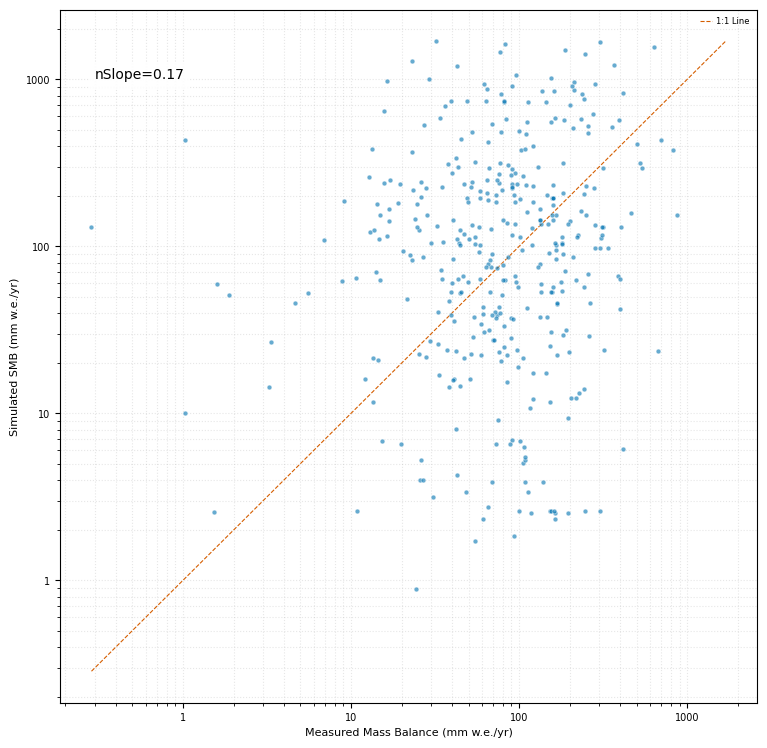

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from scipy import stats
import matplotlib.ticker as ticker

# 设置期刊规范参数
rcParams['font.family'] = 'DejaVu Sans'
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 0.8
rcParams['xtick.major.width'] = 0.8
rcParams['ytick.major.width'] = 0.8

# 读取数据（根据实际变量名调整）
ds1 = xr.open_dataset(
    r'D:/Data/SJY_GLACIER/Grided mass change/dh_swr_0.1deg_1970s-2000_v2.nc', engine='h5netcdf'
)
ds2 = xr.open_dataset(
    r'D:/CSSP/out_data/GLOBAL/CSSPsurface_SMB_GLOBAL1981_1981_glc_cropped_downscaled.nc', engine='h5netcdf'
)

# 提取目标变量（根据实际变量名修改）
mb1 = -ds1['mb']          # 假设第一个文件变量名为'mb'（单位：m/yr）
mb2 = -ds2['mb']          # 假设第二个文件变量名为'mb'（单位：mm w.e./yr')

# 空间对齐与单位转换
mb1_mm = mb1 * 1000*2     # 1m → 1000mm
mb2_aligned = mb2      # 确保空间网格对齐（需根据实际数据验证）

# 过滤负值（对数坐标要求数据>0）
valid_mask = (
    ~np.isnan(mb1_mm.values) & 
    ~np.isnan(mb2.values) & 
    (mb2.values < 2000)   &    
    (mb2.values > 0)  &
    (mb1.values > 0) # 新增条件：仅保留正数
)
x = mb1_mm.values[valid_mask]
y = mb2.values[valid_mask]

# 创建图形
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_facecolor('none')

# 设置对数坐标轴
ax.set_xscale('log')     # X轴对数坐标
ax.set_yscale('log')     # Y轴对数坐标
x =x /5
# 散点图编码
scatter = ax.scatter(
    x,
    y,
    c='#0173B2',
    alpha=0.6,
    edgecolor='white',
    s=12,
    linewidth=0.5,
    zorder=3
)

# 对数坐标下参考线处理
# 1:1参考线在对数坐标下仍为y=x
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
ax.plot([min_val, max_val], [min_val, max_val],
        color='#D55E00',
        linestyle='--',
        linewidth=0.8,
        label='1:1 Line')

# 视觉优化
ax.set_xlabel('Measured Mass Balance (mm w.e./yr)', fontsize=8)
ax.set_ylabel('Simulated SMB (mm w.e./yr)', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=7, direction='out')

# 对数坐标刻度格式
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

# 网格线增强
ax.grid(True, which='both', linestyle=':', alpha=0.3, zorder=0)

# 统计标注（需转换为对数坐标下的回归）
# 注意：对数坐标下建议使用对数转换数据进行回归
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(np.log(x), np.log(y))
ax.text(0.05, 0.9, 
        f"Slope={slope_log:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

# 图例与导出
ax.legend(
    frameon=False,
    fontsize=6,
    handlelength=1.5,
    handletextpad=0.5
)
plt.savefig('mb_comparison_logscale.pdf',
            dpi=600,
            format='pdf',
            transparent=True,
            bbox_inches='tight',
            pad_inches=0.03)
